# Profit Stop-Loss
We can detrmine a profit stop-loss that can close a position once it has lost a pre-defined amount. This can help limit the risk of our strategy and is an important part of a trading algortihm.

We will use a simple SMA cross-over strategy using APPLE stock with a 50 and 100 day moving average. We will backtesrt this and then add a stop loss to see if we reduce the risk. We will use long and short entries.

In [5]:
import bt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf

In [6]:
aapl_data = yf.download(tickers = 'AAPL', start = '2017-01-01', end ='2024-09-30', interval = '1d')

backtest_data = aapl_data.copy()
backtest_data['Open'] = aapl_data['Adj Close']

backtest_data = backtest_data.drop(['High','Low','Close','Adj Close','Volume'], axis = 1)
backtest_data = backtest_data.rename(columns = {'Open' : 'AAPL'})
backtest_data

[*********************100%***********************]  1 of 1 completed


,AAPL
Date,
2017-01-03,26.921545
2017-01-04,26.891415
2017-01-05,27.028166
2017-01-06,27.329489
2017-01-09,27.579807
...,...
2024-09-23,226.470001
2024-09-24,227.369995
2024-09-25,226.369995


Calculate the 50 and 100 day sma. Plot so we can see when we will be buying and selling.

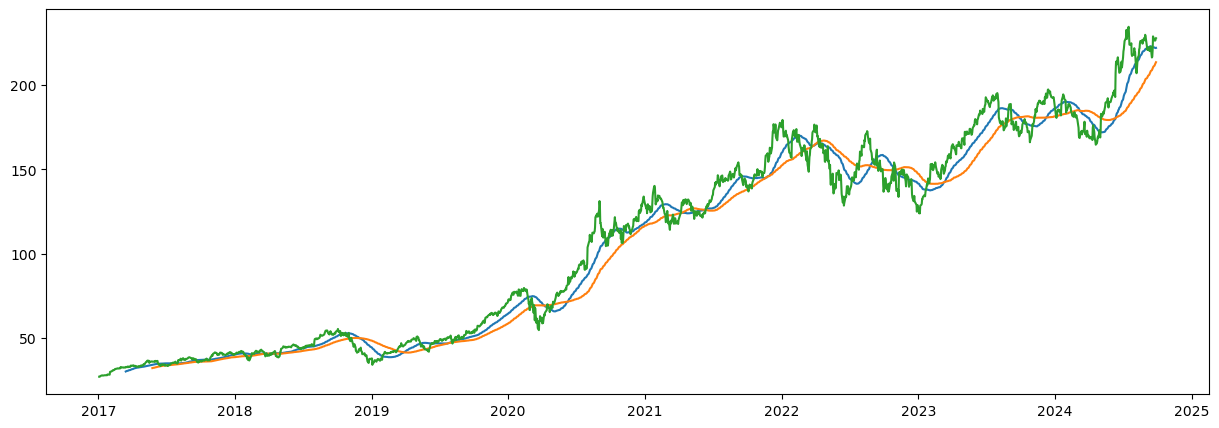

In [7]:
sma_50 = backtest_data.rolling(window = 50).mean()
sma_100 = backtest_data.rolling(window = 100).mean()

plt.figure(figsize = (15,5))
plt.plot(sma_50)
plt.plot(sma_100)
plt.plot(backtest_data)
plt.show()

We create a signal that is 1.0 when we want to enter a long position and -1.0 for a short. 

In [8]:
signal = backtest_data.copy()
signal[:] = 0.0

# Long condition: when the shorter moving average corsses above the longer
condition_1 = (sma_50 > sma_100)

# exit codnition: when the longer above below the shorter
condition_2 = (sma_100 > sma_50)

signal[condition_1] = 1.0
signal[condition_2] = -1.0


We then create the weigh allocation class and backtest.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Stat                 SMA cross over
-------------------  ----------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         36.85%
Daily Sharpe         0.29
Daily Sortino        0.46
CAGR                 4.14%
Max Drawdown         -53.44%
Calmar Ratio         0.08

MTD                  -0.53%
3m                   6.52%
6m                   -14.56%
YTD                  -25.50%
1Y                   -34.75%
3Y (ann.)            -8.52%
5Y (ann.)            4.53%
10Y (ann.)           -
Since Incep. (ann.)  4.14%

Daily Sharpe         0.29
Daily Sortino        0.46
Daily Mean (ann.)    8.38%
Daily Vol (ann.)     29.38%
Daily Skew           0.02
Daily Kurt           5.65
Best Day             11.98%
Worst Day            -12.86%

Monthly Sharpe       0.28
Monthly Sortino      0.53
Monthly Mean (ann.)  8.17%
Monthly Vol (ann.)   28.74%
Monthly Skew         0.07
Monthly Kurt         -0.44
Best Month           21.66%
Worst Month       

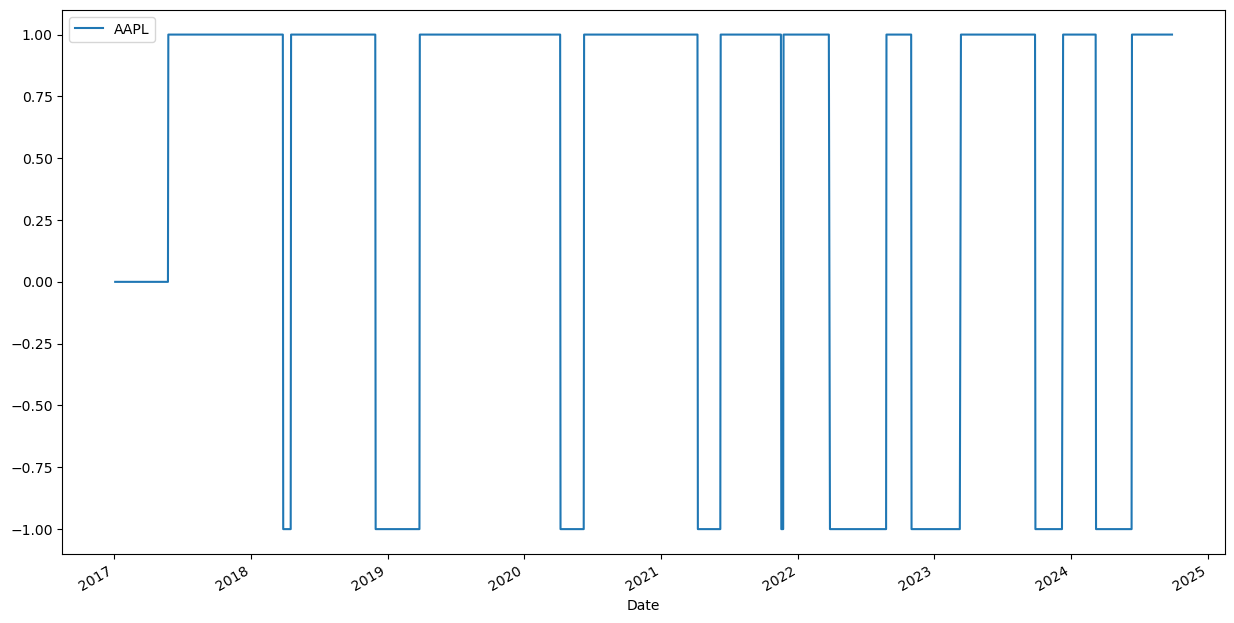

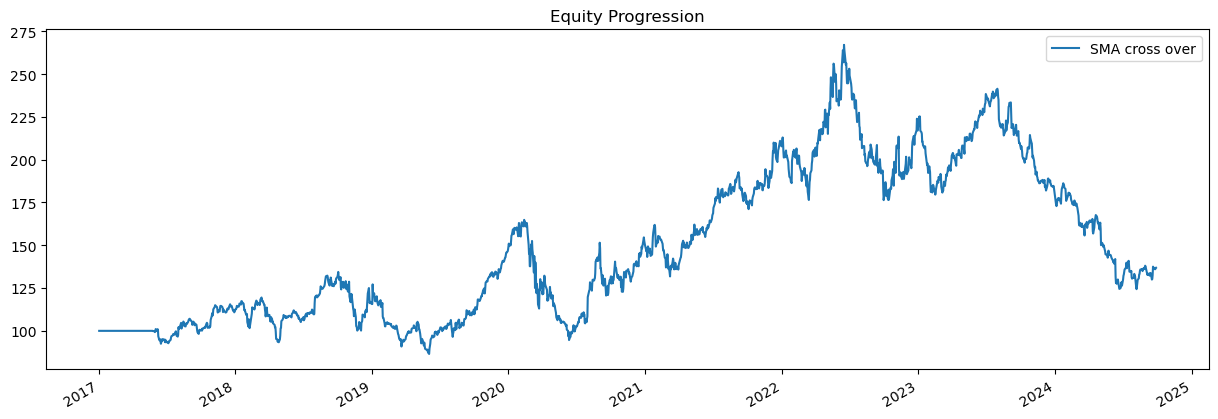

In [9]:

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw =signal.copy()

        
            
# Plot the weighting of the stocks
ax = tw.plot(figsize = (15,8), secondary_y = ['tw'], legend = True)

# Produce the Strategy
s = bt.Strategy('SMA cross over', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()
res.display()

We see that we get a total return of 36.85% with a yearly Sharpe of 0.23. Our avg drawdown was -6.42% and lasted an avg of 53 days.

We will now add a stop loss for both short and long positions. For a short, we cut when the price rises 10% above the entry price. FOr a long we cut when the price falls 10% below the entry. We need to keep track of the entry price of each postition.



## Stop loss with long and short positions

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


Stat                 SMA with sl
-------------------  -------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         40.41%
Daily Sharpe         0.30
Daily Sortino        0.48
CAGR                 4.49%
Max Drawdown         -51.24%
Calmar Ratio         0.09

MTD                  -0.53%
3m                   6.52%
6m                   -14.50%
YTD                  -25.01%
1Y                   -33.72%
3Y (ann.)            -7.10%
5Y (ann.)            5.07%
10Y (ann.)           -
Since Incep. (ann.)  4.49%

Daily Sharpe         0.30
Daily Sortino        0.48
Daily Mean (ann.)    8.70%
Daily Vol (ann.)     29.35%
Daily Skew           0.02
Daily Kurt           5.68
Best Day             11.98%
Worst Day            -12.86%

Monthly Sharpe       0.30
Monthly Sortino      0.55
Monthly Mean (ann.)  8.47%
Monthly Vol (ann.)   28.62%
Monthly Skew         0.08
Monthly Kurt         -0.43
Best Month           21.66%
Worst Month          -18

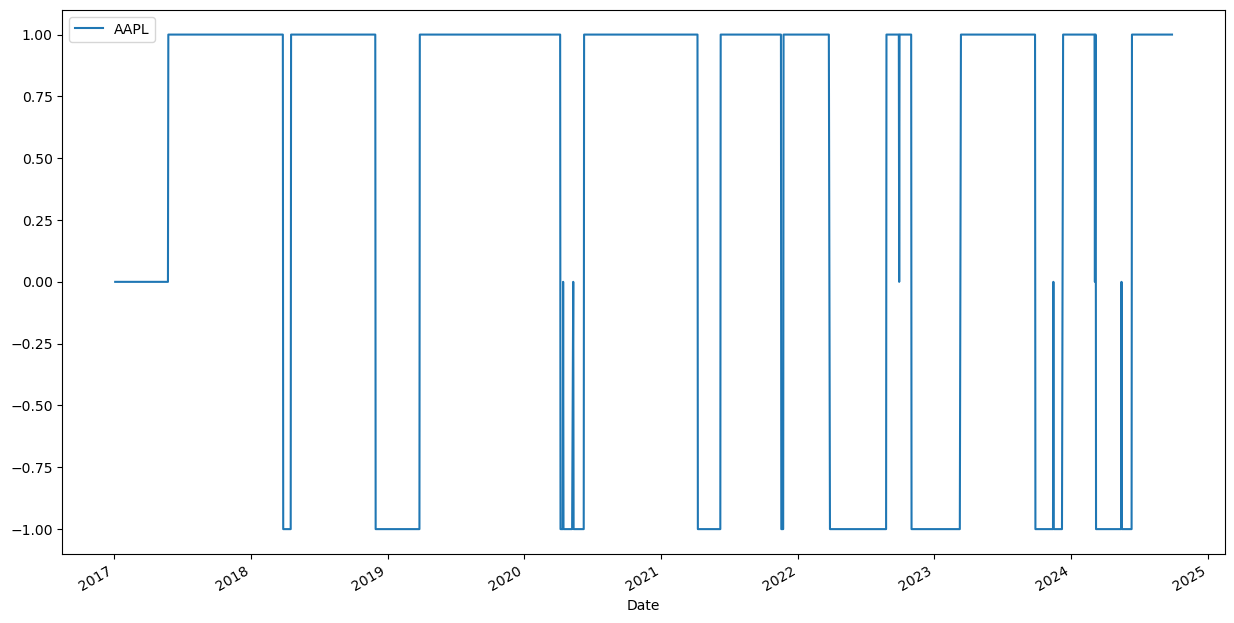

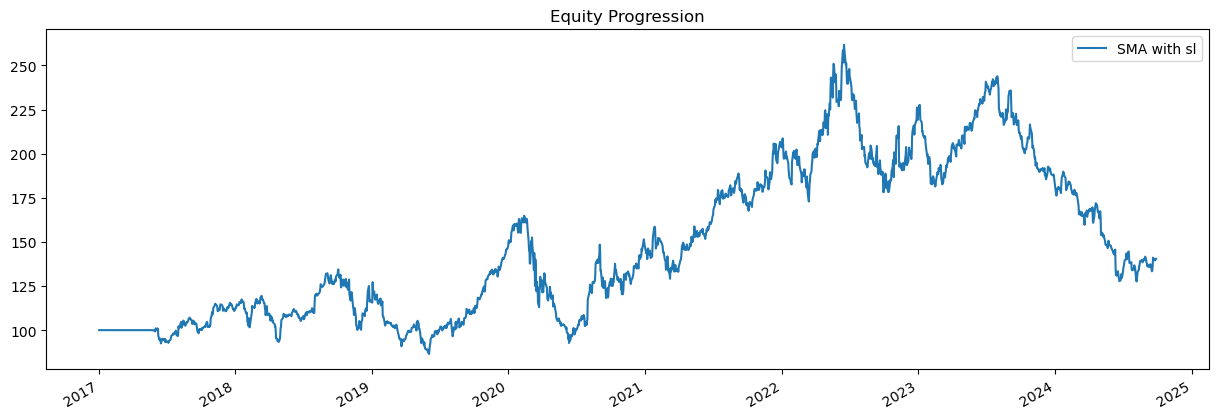

In [10]:
signal = backtest_data.copy()
signal[:] = 0.0

# Long condition: when the shorter moving average corsses above the longer
condition_1 = (sma_50 > sma_100)

# Short codnition: when the longer above below the shorter
condition_2 = (sma_100 > sma_50)

signal[condition_1] = 1.0
signal[condition_2] = -1.0


# Define profit and loss limits
loss_threshold = -0.1  # 10% loss for long positions
short_loss_threshold = 0.1  # 10% loss for short positions (price increases)

def stop_loss(backtest_data, signal, loss_threshold, short_loss_threshold):
    # Track the price when entering a position
    entry_price = np.nan
    position_type = 0  # 1 for long, -1 for short
    
    # Loop through the whole time period
    for i in range(1, len(signal)):
        
        # Current and previous signal 
        current_signal = signal.iloc[i, 0]
        previous_signal = signal.iloc[i-1, 0]

        # Enter long position (but only if not already long)
        if current_signal == 1.0 and position_type != 1:
            # set the entry price
            entry_price = backtest_data.iloc[i]['AAPL']
            # Set the position marker
            position_type = 1  # Long position


        # Enter short position (but only if not already short)
        elif current_signal == -1.0 and position_type != -1:
            # Set the entry price
            entry_price = backtest_data.iloc[i]['AAPL']
            position_type = -1  # Short position


        # Apply stop-loss if a position is open
        if not np.isnan(entry_price):
            # Set current price
            current_price = backtest_data.iloc[i]['AAPL']
            # Calculate teh pct change from the entry of the current position
            pct_change = (current_price - entry_price) / entry_price

            # Stop-loss for long positions (== 1) when the pct change is less than or equal to the threshold
            if position_type == 1 and pct_change <= loss_threshold:
                
                signal.iloc[i, 0] = 0.0  # Exit long position (trigger stop-loss)
                entry_price = np.nan  # Reset entry price
                position_type = 0  # Exit position
                
            # Stop-loss for short positions (==-1.0) when pct change is above the threshold
            elif position_type == -1 and pct_change >= short_loss_threshold:
                
                signal.iloc[i, 0] = 0.0  # Exit short position (trigger stop-loss)
                entry_price = np.nan  # Reset entry price
                position_type = 0  # Exit position

        # Handle if the current signal suggests a neutral position (0.0), reset position
        if current_signal == 0.0:
            entry_price = np.nan
            position_type = 0  # No active position
    
    return signal


# Apply stop-loss to the signal
signal = stop_loss(backtest_data, signal.copy(),  loss_threshold, short_loss_threshold)

# Tw df creation
tw = signal.copy()



ax = tw.plot(figsize = (15,8), secondary_y = ['tw'], legend = True)

# Create the new strat
s = bt.Strategy('SMA with sl', 
                           [bt.algos.RunDaily(),            
                            bt.algos.SelectAll(),           
                            WeighTarget(tw, signal),  
                            bt.algos.Rebalance()])           

# Build backtest
t = bt.Backtest(s, backtest_data)

# Run 
res = bt.run(t)

# Plot 
res.plot()
res.display()


We can see that the stop-loss has had an effect on the strategy. Whilst its not huge it has impacted an improved the risk associated metrics. This could be useful for a more robust and effiecient base strategy.